In [1]:
import numpy as np
import pandas as pd

In [2]:
matches = pd.read_csv('matches.csv')
balls = pd.read_csv('deliveries.csv')

In [3]:
total_score = balls.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()

In [4]:
total_score = total_score[total_score['inning'] == 1]

In [5]:
total_score.head()

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157


In [6]:
matches = matches.merge(total_score[['match_id','total_runs']], left_on='id', right_on='match_id')

In [7]:
matches['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [8]:
curr_playing_teams = [
    'Royal Challengers Bangalore', 'Kings XI Punjab',
    'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
    'Chennai Super Kings', 'Sunrisers Hyderabad', 'Delhi Capitals'
    
]

In [9]:
matches['team1'] = matches['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
matches['team2'] = matches['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')

matches['team1'] = matches['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
matches['team2'] = matches['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')


In [10]:
matches = matches[matches['team1'].isin(curr_playing_teams)]
matches = matches[matches['team2'].isin(curr_playing_teams)]

In [11]:
matches.shape

(641, 20)

In [12]:
matches = matches[matches['dl_applied'] == 0]

In [13]:
matches = matches[['match_id', 'city', 'winner', 'total_runs']]


In [14]:
balls = matches.merge(balls, on='match_id')

In [15]:
balls = balls[balls['inning'] == 2]

In [16]:
balls['curr_score'] = balls.groupby('match_id').cumsum()['total_runs_y']

In [17]:
balls.shape

(72413, 25)

In [18]:
balls['runs_left'] = balls['total_runs_x'] - balls['curr_score']


In [19]:
balls['balls_left'] = 126 - (balls['over']*6 + balls['ball'])

In [20]:
balls['player_dismissed'] = balls['player_dismissed'].fillna("0")
balls['player_dismissed'] = balls['player_dismissed'].apply(lambda x: x if x == "0" else "1")
balls['player_dismissed'] = balls['player_dismissed'].astype('int')
wickets = balls.groupby('match_id').cumsum()['player_dismissed'].values
 


In [21]:
balls['player_dismissed'] = balls['player_dismissed'].astype('int')

In [22]:
wickets = balls.groupby('match_id').cumsum()['player_dismissed'].values

In [23]:
balls['wickets_left'] = 10 - wickets

In [24]:
balls['curr_rr']  = (balls['curr_score'] *6)/(120-balls['balls_left'])

In [25]:
balls['req_rr'] = (balls['runs_left']*6)/balls['balls_left']

In [26]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [27]:
balls['result'] = balls.apply(result, axis = 1)

In [28]:
balls_df = balls[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x','curr_rr','req_rr','result']]

In [29]:
final_df = balls_df.sample(balls_df.shape[0])

In [30]:
final_df.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,curr_rr,req_rr,result
7017,Mumbai Indians,Kolkata Knight Riders,Bangalore,27,54,7,107,7.272727,3.0,1


In [31]:
final_df.dropna(inplace=True)

In [32]:
final_df = final_df[final_df['balls_left'] != 0]

In [33]:
from sklearn.model_selection import train_test_split
X = final_df.iloc[:, :-1]
Y = final_df.iloc[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse=False,drop='first'), ['batting_team', 'bowling_team', 'city'])
],
remainder='passthrough')

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [36]:
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))
])

In [37]:
pipe.fit(X_train, Y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [38]:
y_pred = pipe.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred)

0.8033499194057047

In [40]:
pipe.predict_proba(X_test)[10]

array([0.12801815, 0.87198185])

In [41]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))
    

In [52]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x','curr_rr','req_rr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    

In [53]:
temp_df,target = match_progression(balls,74,pipe)
temp_df

Target- 178


,end_of_over,runs_after_over,wickets_in_over,lose,win
10459,1,4,0,55.2,44.8
10467,2,8,0,49.9,50.1
10473,3,1,0,56.6,43.4
10479,4,7,1,68.4,31.6
10485,5,12,0,58.3,41.7
10491,6,13,0,46.0,54.0
10497,7,9,0,40.1,59.9
10505,8,15,0,26.6,73.4
10511,9,7,0,24.4,75.6
10518,10,17,0,13.3,86.7


Text(0.5, 1.0, 'Target-178')

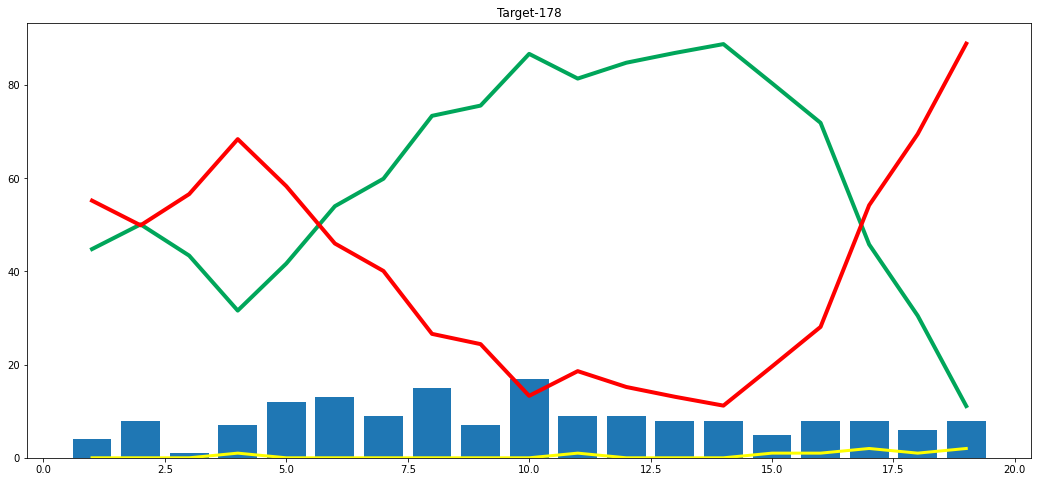

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [55]:
import pickle

In [56]:
pickle.dump(pipe, open('pipe.pkl', 'wb'))

In [59]:
curr_playing_teams

['Royal Challengers Bangalore',
 'Kings XI Punjab',
 'Mumbai Indians',
 'Kolkata Knight Riders',
 'Rajasthan Royals',
 'Chennai Super Kings',
 'Sunrisers Hyderabad',
 'Delhi Capitals']

In [60]:
balls_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)